# Lesson 13, Workalong 01: Finding Earthquakes in California

This workalong uses `geopandas` to find earthquakes within California.  It builds from the [lesson 05 warmup](https://github.com/taobrienlbl/advanced_earth_science_data_analysis/blob/8fdbb61bc39b64244f420d446b985a4d27f80df6/lessons/05_multidimensional_arrays_also_plotting/05_warmup_SOLUTION.ipynb), in which we used pandas to find earthquakes from a USGS dataset.  We'll use a similar approach to initially load the same dataset.

In [15]:
""" Import libraries """
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy
import numpy as np

In [4]:
""" Load the usgs dataset """
dataset_path = "https://raw.githubusercontent.com/taobrienlbl/advanced_earth_science_data_analysis/1cc2bc06219f7c15b211629a2aeba7d57e783138/lessons/05_multidimensional_arrays_also_plotting/data/usgs_major_earthquakes_1900-2023.csv"
usgs_df = pd.read_csv(
    dataset_path,
    header=0,
    parse_dates=[0],
)

# display the data
usgs_df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-09-21 21:11:49.950000+00:00,-14.0039,167.1898,188.419,6.1,mww,76.0,26.0,7.076,0.83,...,2023-09-21T23:17:30.631Z,"41 km WSW of Sola, Vanuatu",earthquake,8.86,4.898,0.054,33.0,reviewed,us,us
1,2023-09-20 14:45:58.609000+00:00,-4.5826,-105.6493,10.000,6.0,mww,110.0,208.0,15.828,1.08,...,2023-09-21T21:02:41.950Z,central East Pacific Rise,earthquake,14.99,1.952,0.050,38.0,reviewed,us,us
2,2023-09-18 13:21:23.790000+00:00,26.4336,125.3032,183.483,6.3,mww,113.0,35.0,2.262,1.21,...,2023-09-19T13:29:35.504Z,"180 km N of Hirara, Japan",earthquake,6.53,4.942,0.044,49.0,reviewed,us,us
3,2023-09-13 11:49:15.926000+00:00,-36.2201,-97.9378,10.000,6.1,mww,117.0,37.0,13.309,0.65,...,2023-09-14T11:52:11.466Z,West Chile Rise,earthquake,10.28,1.860,0.050,39.0,reviewed,us,us
4,2023-09-12 11:03:18.873000+00:00,19.2687,121.2178,41.281,6.3,mww,133.0,21.0,4.049,0.96,...,2023-09-18T13:59:24.715Z,"73 km N of Namuac, Philippines",earthquake,8.03,5.112,0.046,46.0,reviewed,us,us


<Axes: >

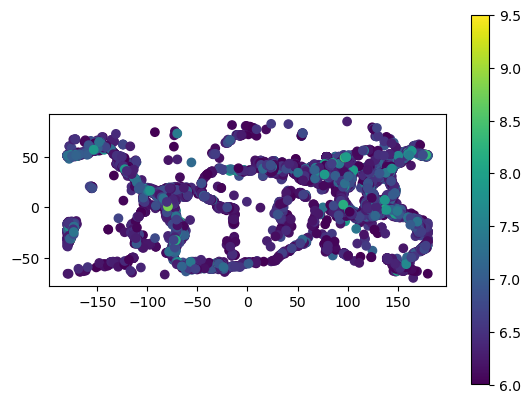

In [7]:
""" Convert the pandas dataframe into a geodataframe """
usgs_gdf = gpd.GeoDataFrame(
    usgs_df,
    geometry=gpd.points_from_xy(
        usgs_df["longitude"],
        usgs_df["latitude"]),
    crs="EPSG:4326", # WGS84 coordinate reference system
    )

# plot the data
usgs_gdf.plot(
    column="mag",
    legend=True,
)

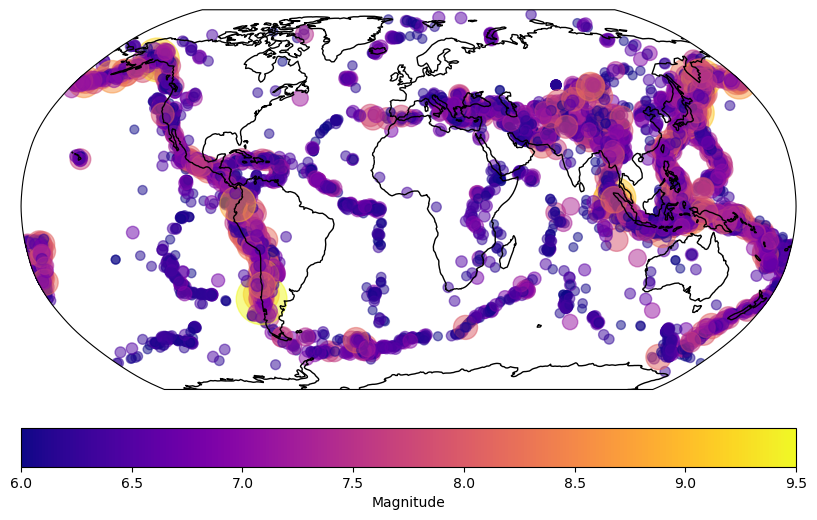

In [19]:
""" Plot the earthquakes by magnitude """
projection = cartopy.crs.Robinson()
fig, ax = plt.subplots(
    figsize=(10, 10),
    subplot_kw={"projection": projection},
    )

# convert the projection to a PROJ4 string, which can be used for converting data to map's projection
proj4 = ax.projection.proj4_init

# make a convereted gdf same projection as the map
usgs_gdf_projected = usgs_gdf.to_crs(proj4)

# plot the data with symbols are proportional to magnitude
usgs_gdf_projected.plot(
    ax=ax,
    column="mag",
    markersize=np.exp(usgs_gdf_projected["mag"])/10,
    alpha=0.5,
    legend=True,
    transform=cartopy.crs.Robinson(), # transform the map only (not the data)
    cmap="plasma", # color map for the data
    legend_kwds=dict(label="Magnitude", orientation="horizontal", pad=0.05), # padding = space between the map and the legend
    )

# add coastlines
ax.coastlines()

## State boundaries

The next step involves filtering by state.  While technically we might be able to determine the location using the "place" column in the dataset, we can do better than that by using a shapefile to define the geospatial region we want to search and then using a point-in-polygon method to find earthquake points taht are within that region.

Note that this shapefile dataset was downloaded from  https://www.sciencebase.gov/catalog/item/52c78623e4b060b9ebca5be5 on Tuesday November 28, 2023 at 1:45pm Eastern.

In [20]:
""" Load the state boundary shapefile. """

state_shapefile_path = "https://github.com/taobrienlbl/advanced_earth_science_data_analysis/raw/09188e9e6a0cf230f8473c0ae95d2e1b9079df3a/lessons/13_geospatial_intro/data/tl_2012_us_state.zip"

# load the shapefile into a geodataframe
state_gdf = gpd.read_file(state_shapefile_path)

# print the first few rows
state_gdf.head()

,OBJECTID,REGION,DIVISION,STATEFP,STATENS,GEOID,STUSPS,NAME,LSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,Shape_Leng,Shape_Area,geometry
0,1,4,9,15,01779782,15,HI,Hawaii,00,G4000,A,1.663425e+10,1.167874e+10,+19.8097670,-155.5061027,2.419034e+06,3.268482e+10,"MULTIPOLYGON (((-17361760.204 2164544.588, -17..."
1,2,3,7,05,00068085,05,AR,Arkansas,00,G4000,A,1.347726e+11,2.959210e+09,+34.8955256,-092.4446262,2.656648e+06,2.053261e+11,"POLYGON ((-10515267.713 4101325.818, -10515269..."
2,3,4,8,35,00897535,35,NM,New Mexico,00,G4000,A,3.141611e+11,7.564385e+08,+34.4346843,-106.1316181,2.900368e+06,4.643927e+11,"POLYGON ((-12138963.727 4106855.170, -12138964..."
3,4,4,8,30,00767982,30,MT,Montana,00,G4000,A,3.769636e+11,3.868565e+09,+47.0511771,-109.6348174,4.607246e+06,8.201836e+11,"POLYGON ((-12727480.235 5886876.586, -12727567..."
4,5,1,2,36,01779796,36,NY,New York,00,G4000,A,1.220579e+11,1.923885e+10,+42.9133974,-075.5962723,3.212630e+06,2.637702e+11,"MULTIPOLYGON (((-8866092.533 5160809.769, -886..."


Since this is a dataframe, we can use pandas features to select rows.  I'm going to pull the row where the "STUSPS" column is "CA".

<Axes: >

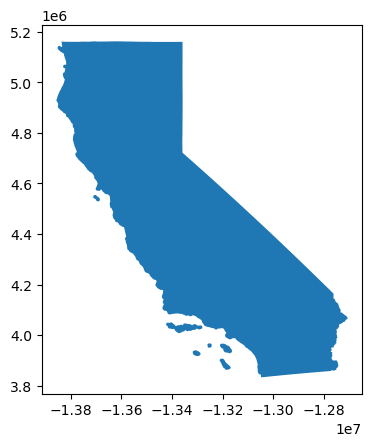

In [24]:
""" Extract the CA row. """
ca_shape_gdf = state_gdf[state_gdf.STUSPS == "CA"]

# plot the data 
ca_shape_gdf.plot()

This particular shapefile seems to include coastal waters that are also part of the state (note how the islands look like dots).  That might not be great for some analyses, but for our purposes, that's just fine.

<Axes: >

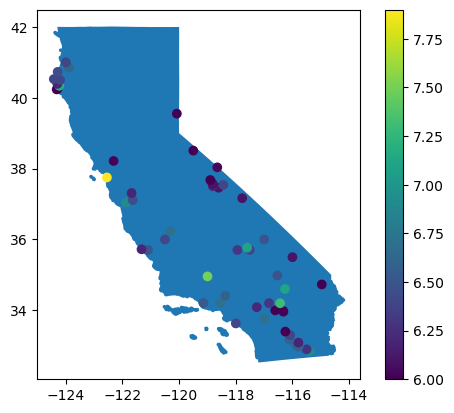

In [26]:
""" Use the CA boundary to clip the earthquakes. """
# convert the projection of this shapefile to the same as the earthquakes
ca_shape_gdf = ca_shape_gdf.to_crs(usgs_gdf.crs)

# clip the earthquakes to the CA boundary
ca_eq_gdf = gpd.clip(usgs_gdf, ca_shape_gdf)

# plot the data
fig, ax = plt.subplots()
ca_shape_gdf.plot(ax=ax)
ca_eq_gdf.plot(ax=ax, column="mag", legend=True)

plt.show()

What if we want earthquakes near CA: e.g., within 100 km?  We can inflate (*buffer*) the shapefile boundary to accomplish this.

Note, however, that the shapefile uses a degree-based coordinate system, so we'll *buffer* by degrees, using the fact that 1 degree is approximately 100 km.

/var/folders/vr/bxyph_y13z17gzq1r_gst6zw0000gn/T/ipykernel_32699/2093414167.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ca_shape_buffered_gdf = ca_shape_gdf.buffer(1)


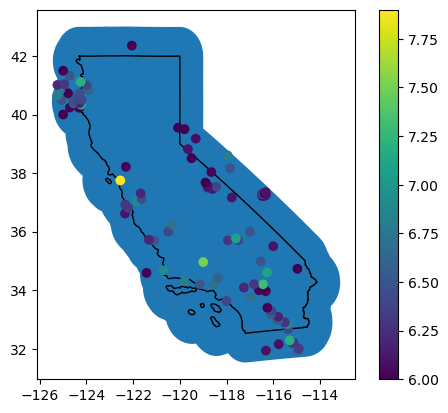

In [31]:
""" Inflate the CA shapefile boundary. """
# buffer the shapefile by 1 degree
ca_shape_buffered_gdf = ca_shape_gdf.buffer(1)

# clip earthquakes to the buffered shapefile
ca_eq_buffered_gdf = gpd.clip(usgs_gdf, ca_shape_buffered_gdf)

# plot the data
fig, ax = plt.subplots()
ca_shape_buffered_gdf.plot(ax=ax)
ca_shape_gdf.plot(ax=ax, color="none", edgecolor="black") # plot the original shapefile boundary
ca_eq_buffered_gdf.plot(ax=ax, column="mag", legend=True)

plt.show()

In [33]:
""" Save the inflated boundary to a shapefile for later use. """
ca_shape_buffered_gdf.to_file("ca_buffered_1_deg.shp.zip", driver="ESRI Shapefile")

In [34]:
""" Save the clipped earthquakes for later use. """
ca_eq_temp = ca_eq_buffered_gdf.copy()

#convert the time column to a string
ca_eq_temp["time"] = ca_eq_temp["time"].astype(str)

ca_eq_temp.to_file("ca_eq_buffered_1_deg.shp.zip", driver="ESRI Shapefile")

/var/folders/vr/bxyph_y13z17gzq1r_gst6zw0000gn/T/ipykernel_32699/3758348159.py:7: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  ca_eq_temp.to_file("ca_eq_buffered_1_deg.shp.zip", driver="ESRI Shapefile")
